#  NOTE: 
    1.The data given on github was not being able to get transformed into data frame by pd.read_csv() function. it was
    giving error.
    2.Hence i have manualy written the code to load data into dataframe.
    3.during the code the title column was having (,) in rows hence the title column was removed and a new csv was 
    created with name changed.csv whle running the code please use that csv. I will be zipping that to with my submission
    please keep that in mind.(Moreover the title column was not apredictive factor for IMDB rating so its safe to remove)
    4. for one of the plot plotly ofline is used for interactive purposes so it might happen when you load the jypyter 
       notebook it might not be visible so please run that part of the code manually.
    5. The analysis is interdependent so avoid running any chunk of code randomly.for best evaluation run the code 
       sequentially.

# Analysis Road Map
    1.Library Imports
    2.User defined functions
    3.Loading Data
    4.Cleaning Data & null value computation..
    5. Exploratory analysis
        1. correlation plot.
        2. Univariate analysis.
        3. By variate analysis.
        4. Director vs Rating's
    6. Data Modeling..
        1. Feature Engineering.
            a.dummy variables for director and actor columns
            b.log transformation for few features.
            c.feature scaling.
            d.Train Test Split
        2. Gradient boosting and Feature importance.
        3. PCA for expediting Machine learning.
        4. Creating Estimators.
        5. Deploying estimators.
        6. Conclusion and Comparing results.

# 1. Library Imports..

In [290]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import plotly.offline as off
from scipy import special
py.offline.init_notebook_mode(connected=True)
from sklearn import preprocessing
from sklearn.decomposition import PCA
le=preprocessing.LabelEncoder()
scaler = preprocessing.StandardScaler()
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
import plotly.figure_factory as ff

# 2. User Defined functions.

In [285]:
# Inbuilt Functions
def cata_numa_col(df):
    categorical=[]
    numerical=[]
    for i in df.columns:
        try:
            float(df[i].iloc[0])
            numerical.append(i)
        except ValueError:
            categorical.append(i)
    return(numerical,categorical)
def finding_isnaperct_fun(df):
    total=len(df)
    remove_na=[]
    impute_na=[]
    for i in df.columns:
        if sum(df[i].isna()) > 0:
            perct=(sum(df[i].isna())/total)*100
            #print(i," ",perct)
            if perct>20:
                remove_na.append(i)
            else:
                impute_na.append(i)
    return(remove_na,impute_na)
def remove_n(x):
    if x!=None and '\n' in x:
        val=x.split("\n")
        return (val[0])
    else:
        return (x)
def label_encoder(ordinal,df):
    inverse=[]
    for i in ordinal:
        k=le.fit(df[i])
        df[i]=le.transform(df[i])
        inverse.append(k.inverse_transform(df[i]))
    return(df,inverse)

def plot_bar_interactive(categorical_column,numerical_column,df):
    aggs = ["count","sum","avg","median","mode","rms","stddev","min","max","first","last"]
    agg=[]
    agg_func=[]
    for i,v in enumerate(aggs):
        agg=dict(
            args=['transforms[0].aggregations[0].func', v],
            label=v,
            method='restyle'
        )
        agg_func.append(agg)
    data = [dict(
    type = 'bar',
    x = df[categorical_column],
    y = df[numerical_column],
    mode = 'markers',
    transforms = [dict(
        type = 'aggregate',
        groups = df[categorical_column],
        aggregations = [dict(
        target = 'y', func = 'sum', enabled = True)
        ]
      )]
    )]

    layout = dict(
          title = '<b>Aggregations Plots</b><br>use dropdown to change aggregation',
          xaxis = dict(title = categorical_column),
          yaxis = dict(title = numerical_column),
          updatemenus = [dict(
                x = 0.85,
                y = 1.15,
                xref = 'paper',
                yref = 'paper',
                yanchor = 'top',
                active = 1,
                showactive = False,
                buttons = agg_func
      )]
    )

    off.iplot({'data': data,'layout': layout}, validate=False)
    
def show_image(y_test_predict,name,y_test):
  ## scattor plot
    plt.figure(figsize=(8,6))
    plt.scatter(y_test_predict[name],y_test,cmap='plasma')
    plt.title(name)
    print('RMSE for ',name,' is ',y_mse[name])

# 3. Loading Data..

In [210]:
with open('changed.csv', 'r') as f:
    results = []
    columns=[]
    for line_no,line in enumerate(f):
        if line_no==0:
            columns.append(line.split(','))
            print(line.split(","))
        else:
            results.append(line.split(','))
df=pd.DataFrame(data=results)
#df=df[df.columns[:-3]]
df.columns=['color', 'director_name', 'num_critic_for_reviews', 'duration',
   'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
   'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
   'num_voted_users', 'cast_total_facebook_likes',
   'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
   'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
   'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
   'imdb_score', 'aspect_ratio', 'movie_facebook_likes']    
for i in df.columns:
    #removing \n from value
    df[i]=df[i].apply(lambda x: remove_n(x))
    #replacing blanks with null values
    df[i]=df[i].apply(lambda x: None if x=="" else x)

['color', 'director_name', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name', 'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language', 'country', 'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio', 'movie_facebook_likes\n']


# 4. Cleaning Data & null value computation..

In [211]:
numerical,catagorical=cata_numa_col(df)
for i in numerical:
    if i !="title_year":
        df[i]=pd.to_numeric(df[i])
remove_na,impute_na=finding_isnaperct_fun(df)
for i in impute_na:
    if i in numerical and i !="title_year":
        #print(i)
        df[i].fillna((df[i].mean()), inplace=True)
remove_na,impute_na=finding_isnaperct_fun(df)
#replacing ordinal values with mode.
for i in impute_na:
    u,p=np.unique(df[i].dropna(),return_counts=True)
    if len(p) < 32:
        print(i,"      ",u[list(p).index(max(p))])
        df[i].fillna(u[list(p).index(max(p))], inplace=True)
# Removing rest of null values.
df.dropna(inplace=True)
df.to_csv("final.csv")
numerical.pop(-5)

color        Color
content_rating        R


'title_year'

# 5. Exploratory analysis
    1. correlation plot.
    2. Univariate analysis.
    3. By variate analysis.
    4. Director vs Rating's

# 5.1 correlation plot.

Text(0.5, 1.0, 'correlation Heat Map')

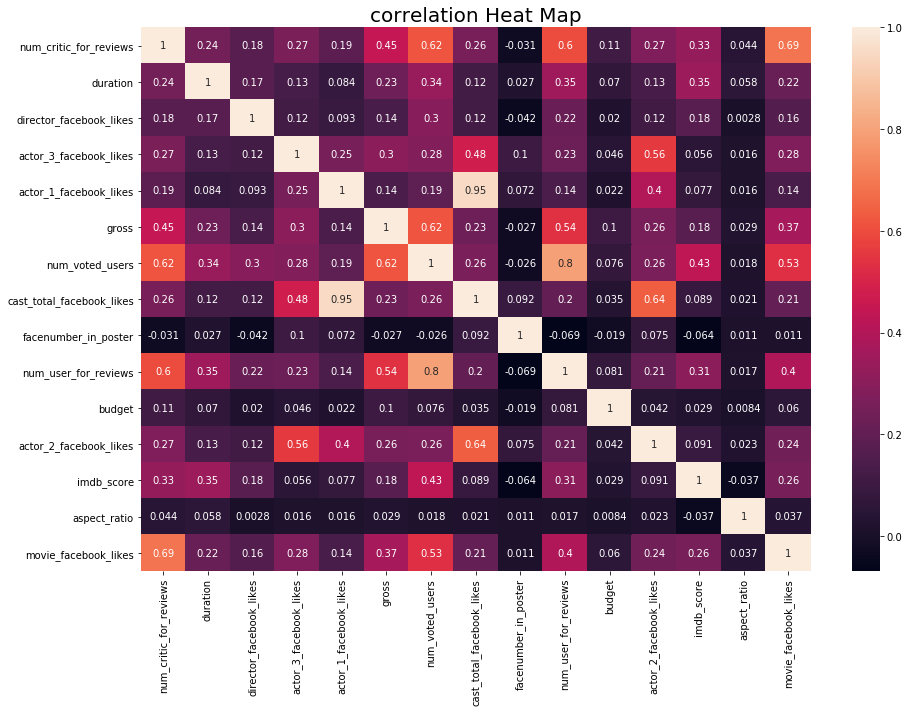

In [212]:
num_df=df[numerical]
plt.figure(figsize=(15,10))
sns.heatmap(num_df.corr(),annot=True)
plt.title("correlation Heat Map",fontsize=20)

correlation plot Inference: Keeping our target variable in mind we see that IMDB score has correlations with following feature.
1. num_critic_for_reviews.
2. duration
3. number_voted users
4. num_users for review
5. to some extent of movie_facebook likes

# 5.2 Univariate analysis

Text(0.5, 0.98, 'Density plots for interested features')

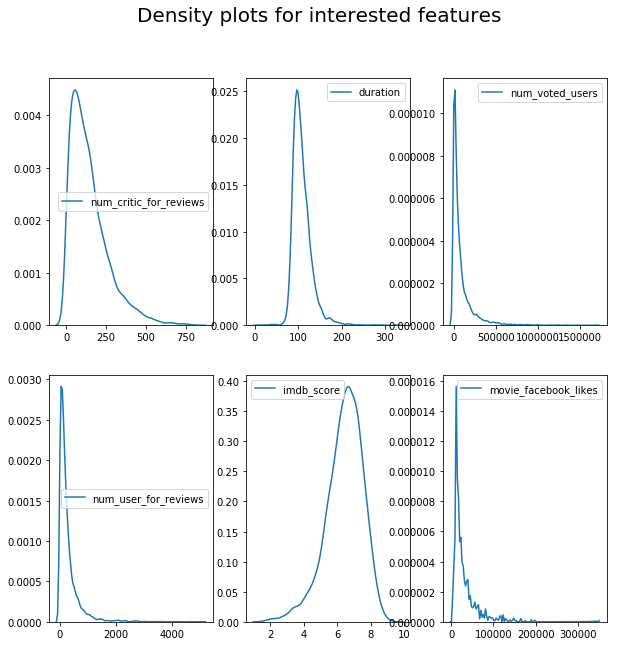

In [213]:
interested_features=["num_critic_for_reviews","duration","num_voted_users","num_user_for_reviews","imdb_score","movie_facebook_likes"]
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(10,10))
count=0
for row in ax:
    for col in row:
        sns.kdeplot(df[interested_features[count]],ax=col)
        count=count+1
fig.suptitle('Density plots for interested features',fontsize=20)

After seeing the plots features num_voted_users,num_user_for reviews and movie facebook likes needs transformation as they are highly skwed.

# 5.3 Byvariate analysis.

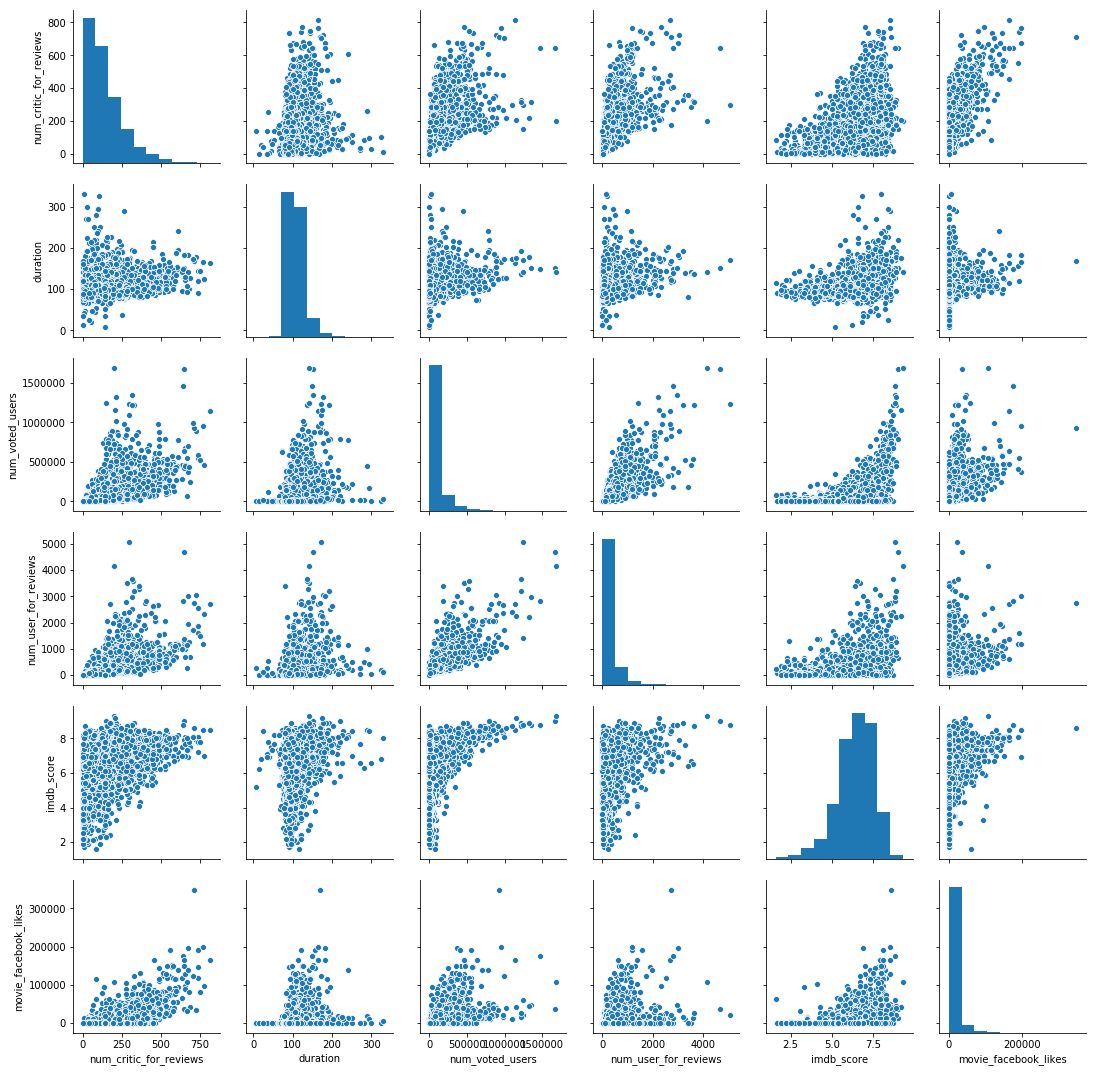

In [214]:
sns.pairplot(df[interested_features])

the graphs depits the correlations as said above 

# 5.4 Director vs Imdb ratings.

In [215]:
# frequency is taken randomly 
u,v= np.unique(df["director_name"],return_counts=True)
mostfrequent=[u[i] for i,k in enumerate(v) if k >=12]
mostfrequent
#subseting data on most frequent directors.
freqdirec=df[(df["director_name"]=='Barry Levinson')|(df["director_name"]=='Brian De Palma')|(df["director_name"]=='Clint Eastwood')|
  (df["director_name"]=='Joel Schumacher')|(df["director_name"]=='John Carpenter')|(df["director_name"]=='Kevin Smith')|
  (df["director_name"]=='Martin Scorsese')|(df["director_name"]=='Michael Bay')|(df["director_name"]=='Oliver Stone')|
  (df["director_name"]=='Peter Jackson')|(df["director_name"]=='Renny Harlin')|(df["director_name"]=='Richard Donner')|
  (df["director_name"]=='Ridley Scott')|(df["director_name"]=='Robert Rodriguez')|(df["director_name"]=='Ron Howard')|
  (df["director_name"]=='Sam Raimi')|(df["director_name"]=='Shawn Levy')|(df["director_name"]=='Spike Lee')|
  (df["director_name"]=='Steven Soderbergh')|(df["director_name"]=='Steven Spielberg')|(df["director_name"]=='Tim Burton')|
  (df["director_name"]=='Tony Scott')|(df["director_name"]=='Wes Craven')|(df["director_name"]=='Woody Allen')]
plot_bar_interactive("director_name",'imdb_score',freqdirec)

from the above graph we can see that imdb ratings also depends on the calibur of director and that makes sense more experienced and mature directos will make better movies thus will be liked by everyone hence ratings will boom. Same is true with acttors as well. SO while data modeling phase we cant ignore these features. Hence feature engineering is needed for both directors and actors.

# 6. Data Modeling..
    1. Feature Engineering.
        a.dummy variables for director and actor columns
        b.log transformation for few features.
        c.feature scaling.
        d.Train Test Split
    2. Gradient boosting and Feature importance.
    3. PCA for expediting Machine learning.
    4. Creating Estimators.
    5. Deploying estimators.
    6. Conclusion and Comparing results.

# 6.a Creating dummy variables for director and actor

In [216]:
model_columns=['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster','num_user_for_reviews','content_rating',
       'budget','actor_2_facebook_likes', 'imdb_score',
       'aspect_ratio', 'movie_facebook_likes']
df1=df[model_columns]
cata=[i for i in df1.columns if i in catagorical]
cata
dict_={}
for i in cata:
    dict_[i]=text=pd.get_dummies(df1[i])
model_df=pd.concat([df1,dict_['color'],dict_['director_name'],dict_['actor_2_name'],dict_['actor_1_name'],
              dict_['actor_3_name'],dict_['content_rating']],axis=1)
model_df.drop(cata,inplace=True,axis=1)

# 6.b log transformation for few features.

C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



Text(0.5, 0.98, 'Density plots for transformed features')

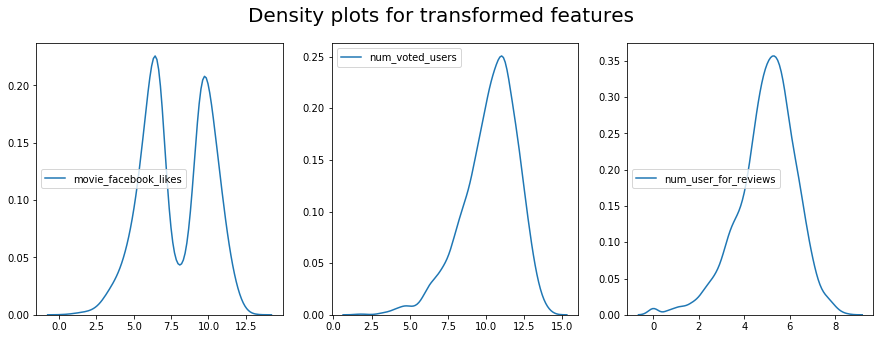

In [217]:
lf=["movie_facebook_likes","num_voted_users","num_user_for_reviews"]
for i in lf:
    df[i]=np.log(df[i])
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
count=0
for row in ax:
    #for col in row:
        sns.kdeplot(df[lf[count]],ax=row)
        count=count+1
fig.suptitle('Density plots for transformed features',fontsize=20)

# 6.c Train Test Split

In [223]:
independent=[i for i in model_df.columns if i != "imdb_score"]
target=["imdb_score"]
X=model_df[independent]
y=model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6.d feature scaling.

In [226]:
scaler.fit(X_train)
X_train_tr = scaler.transform(X_train)
X_test_tr  = scaler.transform(X_test)

C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.



# 6.2. Gradient boosting and Feature importance.

In [230]:
learning_rates = [0.1,0.5,0.75,1,0.001]
for learning_rate in learning_rates:
    gb = GradientBoostingRegressor(n_estimators=2000, learning_rate = learning_rate, max_features='auto', random_state = 0)
    gb.fit(X_train_tr, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_tr, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test_tr, y_test)))
    print()

C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Learning rate:  0.1
Accuracy score (training): 0.892
Accuracy score (validation): 0.501



C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Learning rate:  0.5
Accuracy score (training): 0.997
Accuracy score (validation): 0.413



C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.364



C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.283



C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Learning rate:  0.001
Accuracy score (training): 0.414
Accuracy score (validation): 0.375



In [234]:
gb = GradientBoostingRegressor(n_estimators=2000, learning_rate = 0.1, max_features='auto', random_state = 0)
gb.fit(X_train_tr, y_train)
print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_tr, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test_tr, y_test)))

C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Accuracy score (training): 0.892
Accuracy score (validation): 0.501


In [251]:
dicts={}
for i,v in zip(X_train.columns,gb.feature_importances_):
    if i not in dicts:
        dicts[i]=v
    if i in dicts and dicts[i] < v:
        dicts[i]=v
# printing out top 25 features.
name=[]
importance=[]
for i,(v,x) in enumerate(sorted(dicts.items(),key=lambda x: x[1],reverse=True)):
    if i<=30:
        name.append(v)
        importance.append(x)
        print("The importance of : "+v+" is : "+str(x))

The importance of : num_voted_users is : 0.25851186263597575
The importance of : duration is : 0.10415504545777612
The importance of : budget is : 0.08068252418765334
The importance of : gross is : 0.037796136092971375
The importance of : actor_3_facebook_likes is : 0.024940545664527487
The importance of : num_user_for_reviews is : 0.019665200827904742
The importance of : movie_facebook_likes is : 0.0175444266743636
The importance of : actor_2_facebook_likes is : 0.012745606600318739
The importance of : num_critic_for_reviews is : 0.012497400729913847
The importance of : PG-13 is : 0.011801855256681317
The importance of : actor_1_facebook_likes is : 0.010090252519524442
The importance of : Jason Friedberg is : 0.009482508714868127
The importance of : director_facebook_likes is : 0.008303504171872797
The importance of : Color is : 0.007036424787260329
The importance of : Uwe Boll is : 0.006107207872751869
The importance of : Craig Moss is : 0.004988269837309608
The importance of : cast_

plotting variable impportance....

Text(0.5, 1.0, 'Variable Importance Plot..')

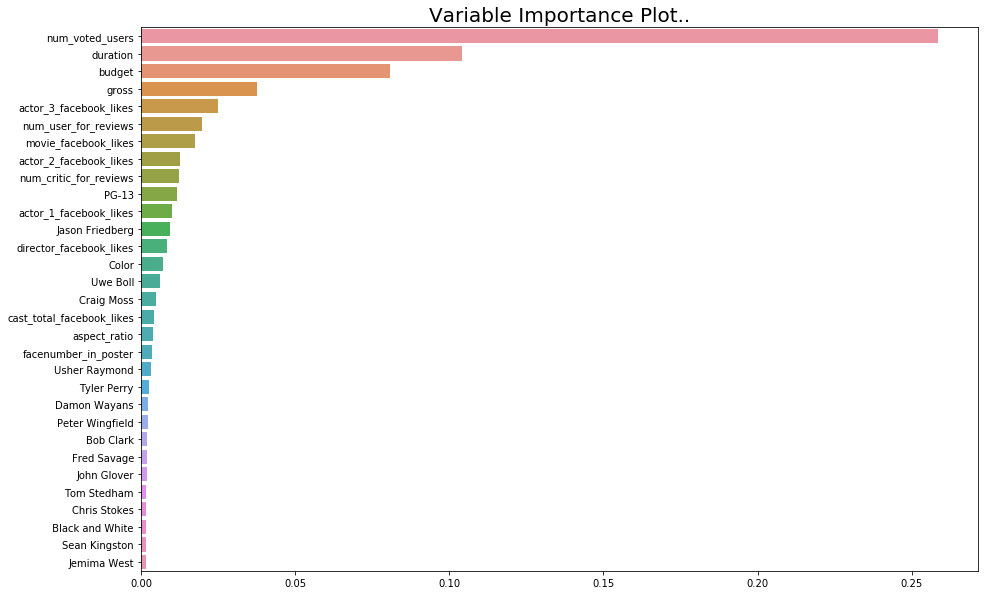

In [258]:
plt.figure(figsize=(15,10))
sns.barplot(importance,name)
plt.title("Variable Importance Plot..",fontsize=20)

# 6.3 PCA for expediting Machine learning.
    Why need PCA?
    Ans. As we created dummy variables in our model there was feature explosion.Hence PCA was needed to solve two problem
        a. To kill variance inflamation factor.
        b. To shrink the features so that the shrinked features exmplained 95 percent variance in our dependent variable.  

In [260]:
pca = PCA(.95)
pca.fit(X_train_tr)
train_pca = pca.transform(X_train_tr)
test_pca = pca.transform(X_test_tr)

# 6.4  Creating Estimators

In [296]:
#Running all models on default parameters
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10,
                                       max_features=32,     
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),                          
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(max_depth=4, random_state=2),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=5)
   
}

# 6.5 Deploying Estimators

C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RMSE for  Extra trees  is  1.2392981145251396


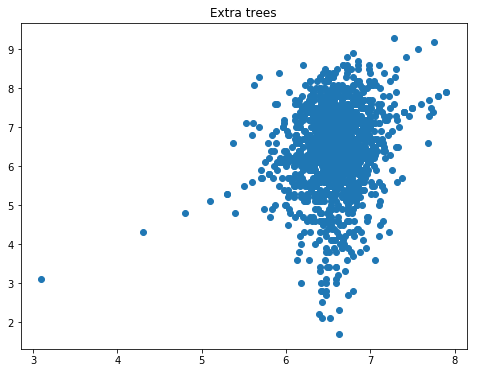

RMSE for  K-nn  is  2.2329050279329614


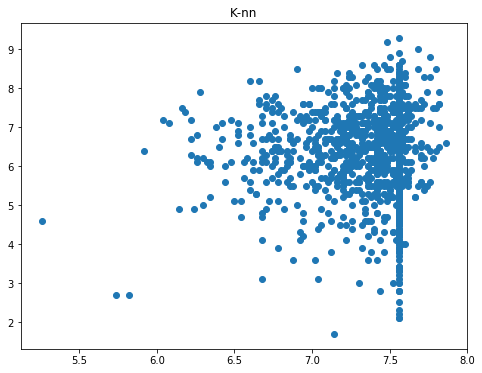

RMSE for  Linear regression  is  1.0441426114081416


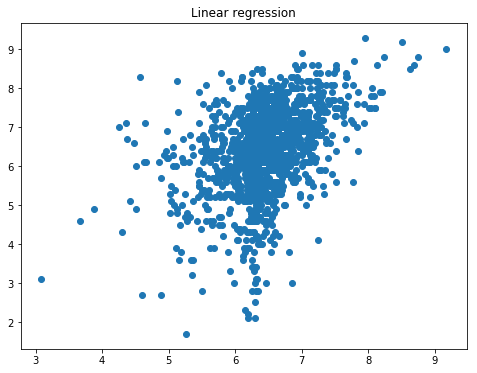

RMSE for  Ridge  is  1.0440229954785525


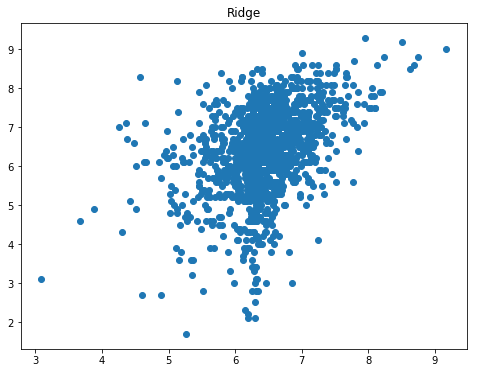

RMSE for  Lasso  is  1.2414539462160168


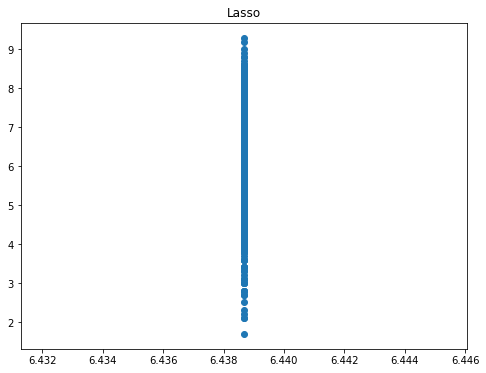

RMSE for  ElasticNet  is  1.1902274270730948


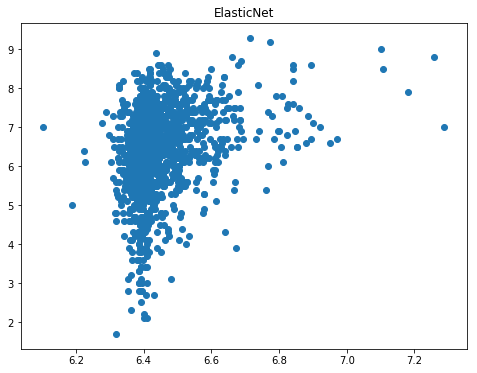

C:\Users\rohan\Anaconda3\envs\Data_Science\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RMSE for  RandomForestRegressor  is  1.0689734134890982


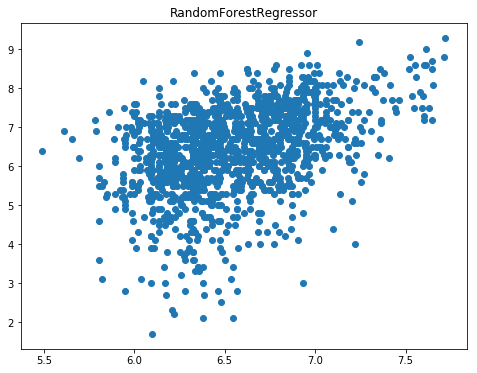

RMSE for  Decision Tree Regressor  is  1.1371910363654676


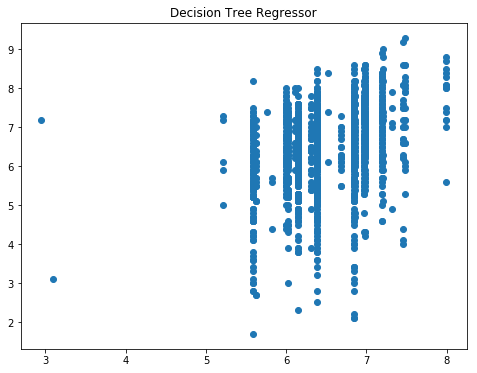

In [299]:
y_test_predict = dict()
y_mse = dict()
for name, estimator in ESTIMATORS.items():     
    estimator.fit(train_pca, y_train) 
    y_test_predict[name] = estimator.predict(test_pca)
    y_mse[name] = mean_squared_error(y_test, estimator.predict(test_pca))
    show_image(y_test_predict,name,y_test)
    plt.show()

# 6.6 Conclusion comparing results.
        1.After seeing all the plots and the root mean square of diffrent models.
            a. In General all models are performing really bad as their RMS value >= 0.5
            b. This can be improved by using cross validations for every estimator and then predicting on the test data.
               the above step would involve playing with the hyperparameters that would surley deacrease the MSE.
            c. Based on the gradient boosting approach. I found that the model is doing good on the traing data
               but the score on test data is bad. Keeping the learning curve in mind i suggest geeting more 
               training data can help.
            d. Given the shortage of time and computation power of my computer i am not able to do grid cv best params 
               for all estimators. Given the cloud senario we can run diffrent models on diffrent node with diffrent 
               hyperparameters and then select the best model.
            e. for now given what i have the best model to go with is Randomforest regressor and ridge regressor.
         2. Assumptions:
             a. Budget is replaced with mean value. which should'nt have beeen done as movies were created in diffrent 
                time frame thus inflamation factor's are not taken into consederation while doing the analysis.
             

# Analysis by Rohan Gupta! Thank You